In [4]:
import numpy as np
from mesa import Agent, Model
from mesa.datacollection import DataCollector
import matplotlib.pyplot as plt

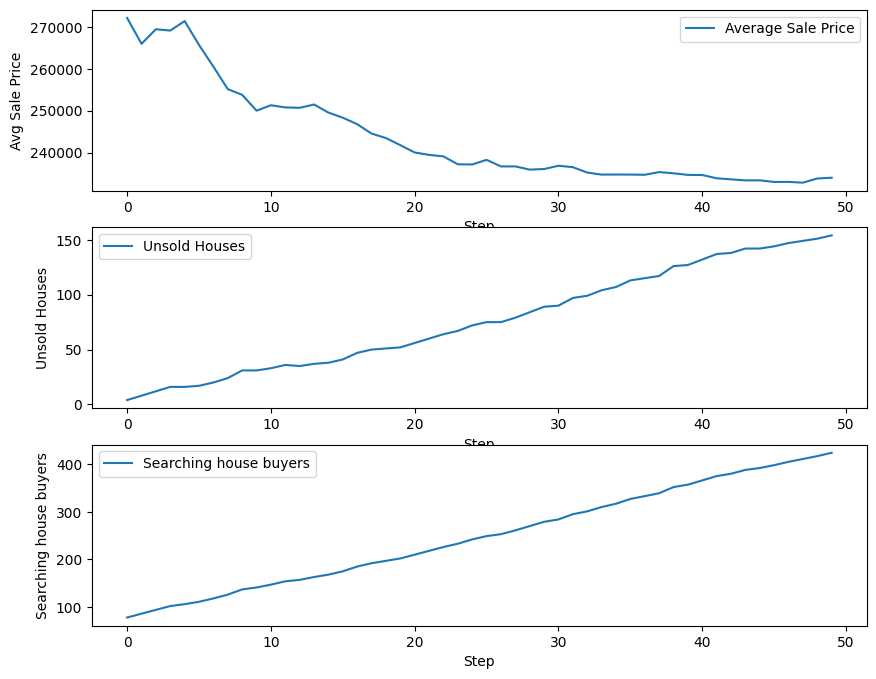

In [44]:
#poging 2 -> is meer een echt agent based model

# Kan volgens leraar zonder Mesa en mesa is miss een beetje overkill, aangezien het te veel kan.
# Voor 8 uur 17 januari github link inleveren.

#Plan:
#   Echte situatie van een jaar of 10 proberen te maken.
#   Vervolgens die situatie gebruiken om interest rates aan te passen. 

# Hoe?
#   Duidelijke regels hebben voor koop en verkoop.
#   Uitbreiden met bijvoorbeeld locatie, type huis, grote huis -> kan miss met score voor voorkeur.
#   Hoeveelheid kopers en verkopers kan impact hebben op kosten van huis.

class BuyerAgent(Agent):
    def __init__(self, model, interest_rate):
        super().__init__(model)
        # assumption people are willing to pay between 30 and 50 % of salary.
        interest_rate_monthly = interest_rate / 100 / 12
        #Us avarage of percentage to mortage in US is 25 - 30 %
        willing_to_pay = np.random.randint(15, 45) / 100
        #assumption paying mortage in 30 years. 30 * 12 = 360 payments.
        payments = 12 * 30
        self.salary = np.random.randint(1000, 5000)
        # M = P * (r * (1 + r)^360) / ((1 + r)^360 - 1) based on https://www.bankrate.com/mortgages/mortgage-calculator/#calculate-mortgage-payment
        # P is principal loan amount, M is monthly payment (here max monthly payment) and r = interest rate
        # Omgerekend = P = M / (r * (1 + r)^360) / ((1 + r)^360 - 1)
        M = self.salary * willing_to_pay
        self.budget = (M * ((1 + interest_rate_monthly)**payments - 1)) / (interest_rate_monthly * (1 + interest_rate_monthly)**payments)
        self.house_bought = False


        #oude manier:
        # interest rates zorgen ervoor dat financieren huis moeilijker wordt dus gaat budget omlaag op basis van interest rate
        self.budget2 = int(np.random.randint(100000, 600000) * (1 - interest_rate / 100))

    def buy_house(self, model):
        """Function that buys a house"""
        if self.house_bought == False:
            sellers = [agent for agent in model.agents if isinstance(agent, SellerAgent) and not agent.house_sold]
            affordable_sellers = [seller for seller in sellers if seller.cost <= self.budget]
            if affordable_sellers:
                chosen_seller = self.random.choice(affordable_sellers)
                self.house_bought = True
                chosen_seller.house_sold = True
                model.sales.append(chosen_seller.cost)


class SellerAgent(Agent):
    def __init__(self, model):
        super().__init__(model)
        self.cost = np.random.randint(100000, 500000)
        self.orig_cost = self.cost
        self.house_sold = False

    def lower_cost(self):
        """Function that lowers the cost after a turn if the house isn't sold"""
        # Als huis niet verkocht wordt, wordt de prijs verlaagt. Gebeurt tot een waarde van 80 % van orginele kosten.
        if self.house_sold == False and self.cost >= self.orig_cost * 0.8:
            self.cost = self.cost * 0.95
    

class House_Model(Model):
    def __init__(self, number_of_buyers, number_of_sellers, seed=None, interest_rate=4.75):
        super().__init__(seed=seed)
        self.num_buyers = number_of_buyers
        self.num_sellers = number_of_sellers
        self.interest_rate = interest_rate
        
        BuyerAgent.create_agents(self, self.num_buyers, self.interest_rate)
        SellerAgent.create_agents(self, self.num_sellers)

        # Data collector
        self.datacollector = DataCollector(
            model_reporters={
                "Average Sale Price": self.compute_avg_sale_price,
                "Unsold Houses": self.compute_unsold_inventory,
                "Searching house buyers": self.compute_num_house_buyers,
            },
        )

        self.sales = []
        self.agents.select(agent_type = BuyerAgent).shuffle_do("buy_house", self)

    def step(self):
        self.add_agents_per_step()
        self.agents.select(agent_type = BuyerAgent).shuffle_do("buy_house", self)
        self.lower_prices_not_sold()
        self.datacollector.collect(self)
    
    def lower_prices_not_sold(self):
        sellers = [agent for agent in self.agents if isinstance(agent, SellerAgent) and not agent.house_sold]
        for seller in sellers:
            seller.lower_cost()

    def compute_avg_sale_price(self):
        if self.sales:
            return np.mean(self.sales)  
        else:
            return 0

    def compute_unsold_inventory(self):
        sellers = [agent for agent in self.agents if isinstance(agent, SellerAgent)]
        return sum(1 for seller in sellers if not seller.house_sold)

    def compute_num_house_buyers(self):
        buyers = [agent for agent in self.agents if isinstance(agent, BuyerAgent)]
        return sum(1 for buyer in buyers if not buyer.house_bought)
    
    def add_agents_per_step(self):
        num_extra_buyers = 15 # baseren op groei bevolking
        num_extra_sellers = 2 + int(13 - self.interest_rate) #baseren op iets -> gedachte nu: hogere interest rates = duurder lenen = miner huizen gebouwd.
        BuyerAgent.create_agents(self, num_extra_buyers, self.interest_rate)
        SellerAgent.create_agents(self, num_extra_sellers)



model = House_Model(number_of_buyers=80, number_of_sellers=10, interest_rate=4.0)

for i in range(50):
    model.step()

results = model.datacollector.get_model_vars_dataframe()
# print(results)

plt.figure(figsize=(10, 8))

plt.subplot(311)
plt.plot(results['Average Sale Price'], label='Average Sale Price')
plt.xlabel('Step')
plt.ylabel('Avg Sale Price')
plt.legend()

plt.subplot(312)
plt.plot(results['Unsold Houses'], label='Unsold Houses')
plt.xlabel('Step')
plt.ylabel('Unsold Houses')
plt.legend()

plt.subplot(313)
plt.plot(results['Searching house buyers'], label='Searching house buyers')
plt.xlabel('Step')
plt.ylabel('Searching house buyers')
plt.legend()

plt.show()
